In [5]:
%pip install prophet

  Using cached prophet-1.1.6-py3-none-win_amd64.whl.metadata (3.6 kB)
  Using cached cmdstanpy-1.2.5-py3-none-any.whl.metadata (4.0 kB)
  Using cached holidays-0.72-py3-none-any.whl.metadata (37 kB)
  Using cached importlib_resources-6.5.2-py3-none-any.whl.metadata (3.9 kB)
  Using cached stanio-0.5.1-py3-none-any.whl.metadata (1.6 kB)
Using cached prophet-1.1.6-py3-none-win_amd64.whl (13.3 MB)
Using cached cmdstanpy-1.2.5-py3-none-any.whl (94 kB)
Using cached holidays-0.72-py3-none-any.whl (932 kB)
Using cached importlib_resources-6.5.2-py3-none-any.whl (37 kB)
Using cached stanio-0.5.1-py3-none-any.whl (8.1 kB)
Note: you may need to restart the kernel to use updated packages.


C:\Users\Tanish\AppData\Local\Temp\ipykernel_37580\3555790670.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['Sales'] = filtered_data['Sales'].astype(float)


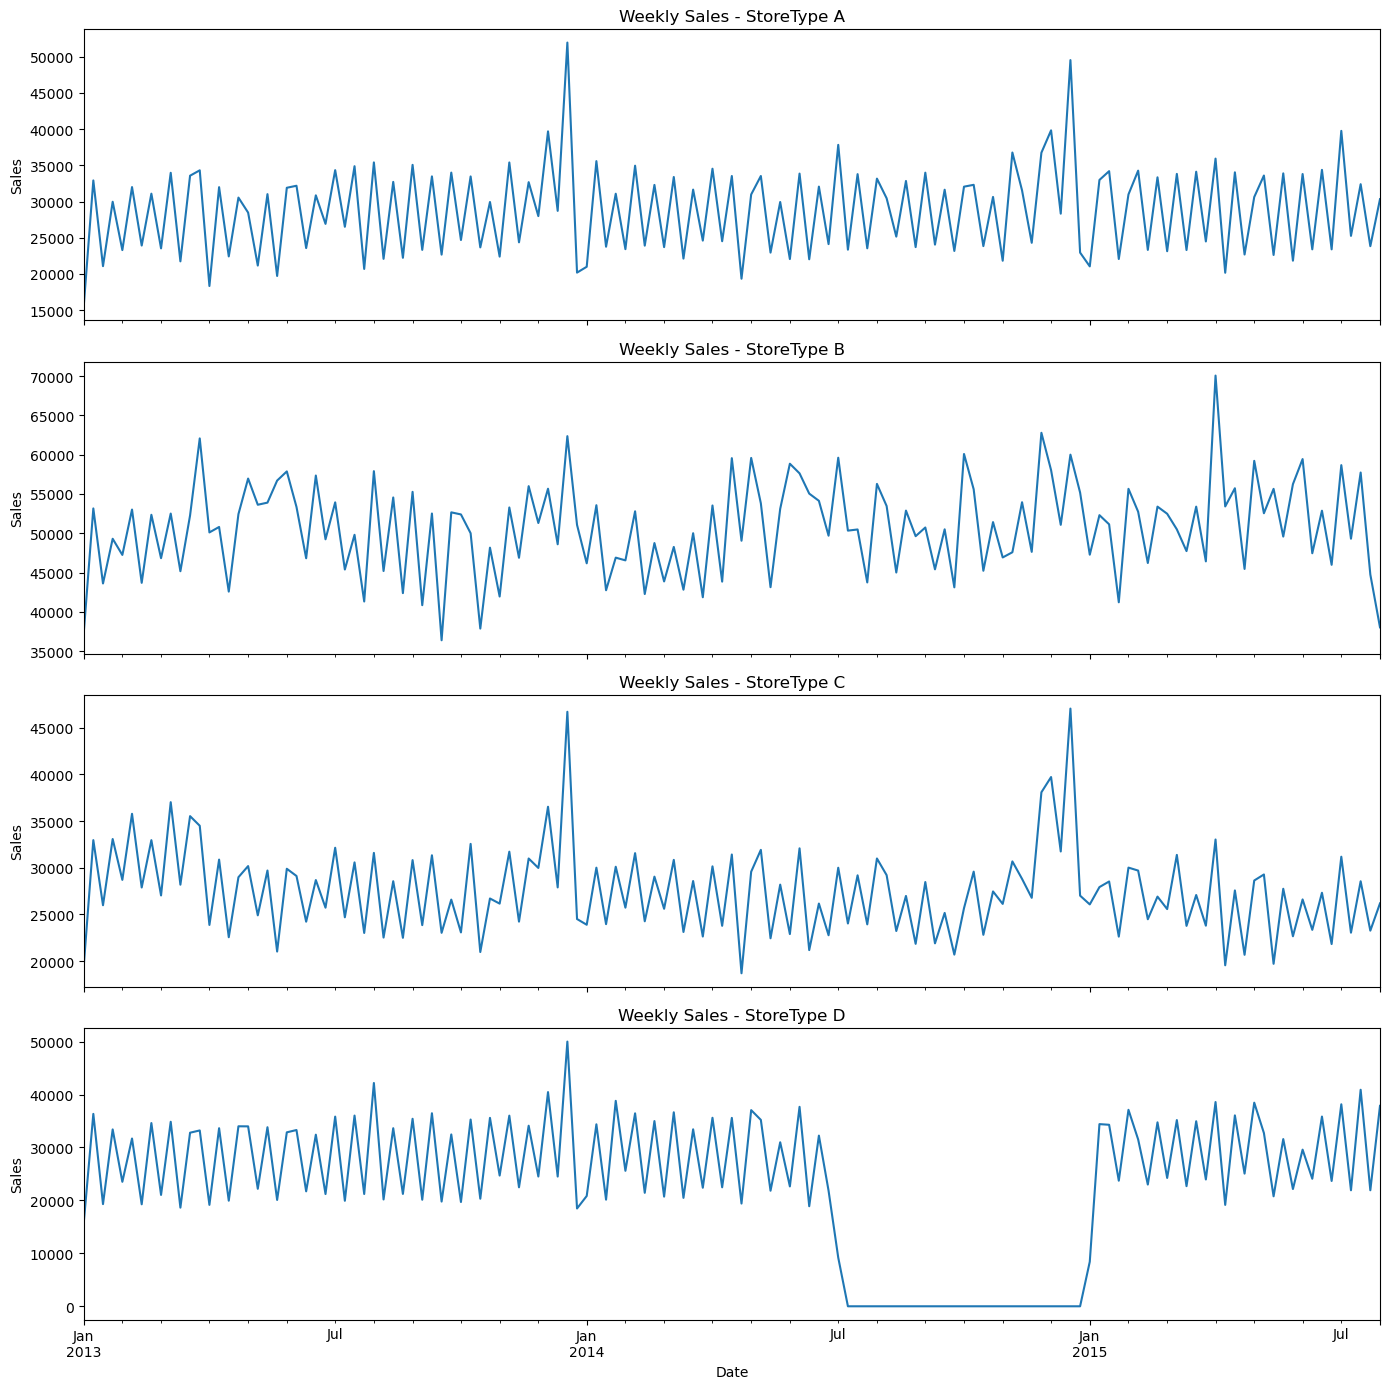

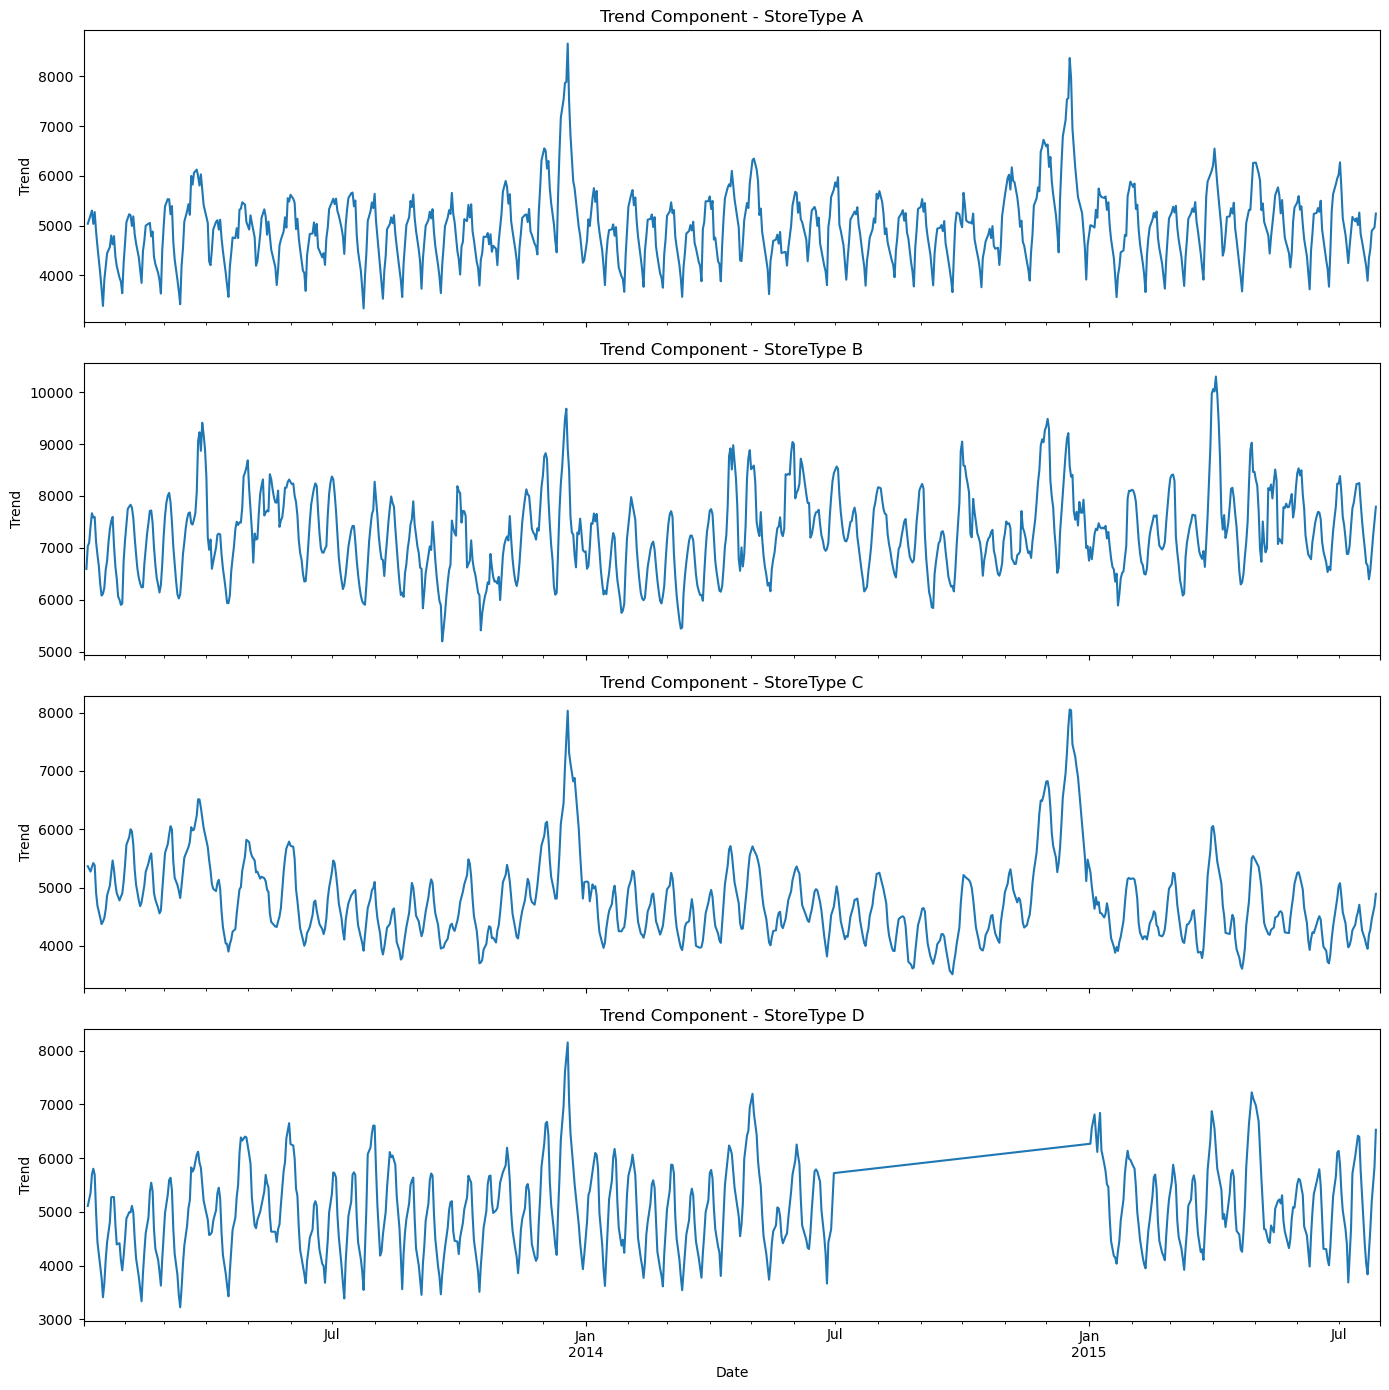

19:54:01 - cmdstanpy - INFO - Chain [1] start processing
19:54:01 - cmdstanpy - INFO - Chain [1] done processing


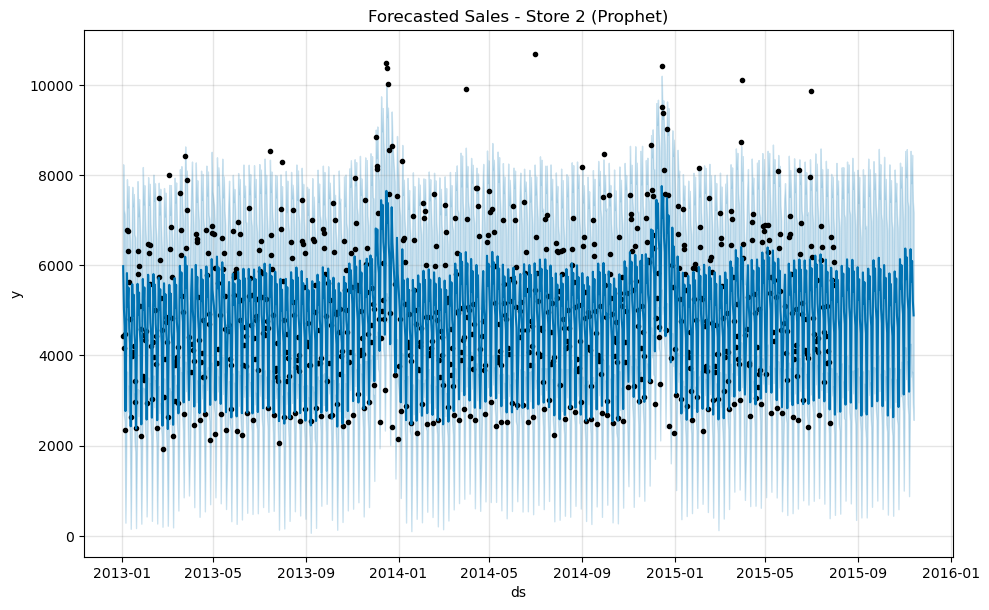

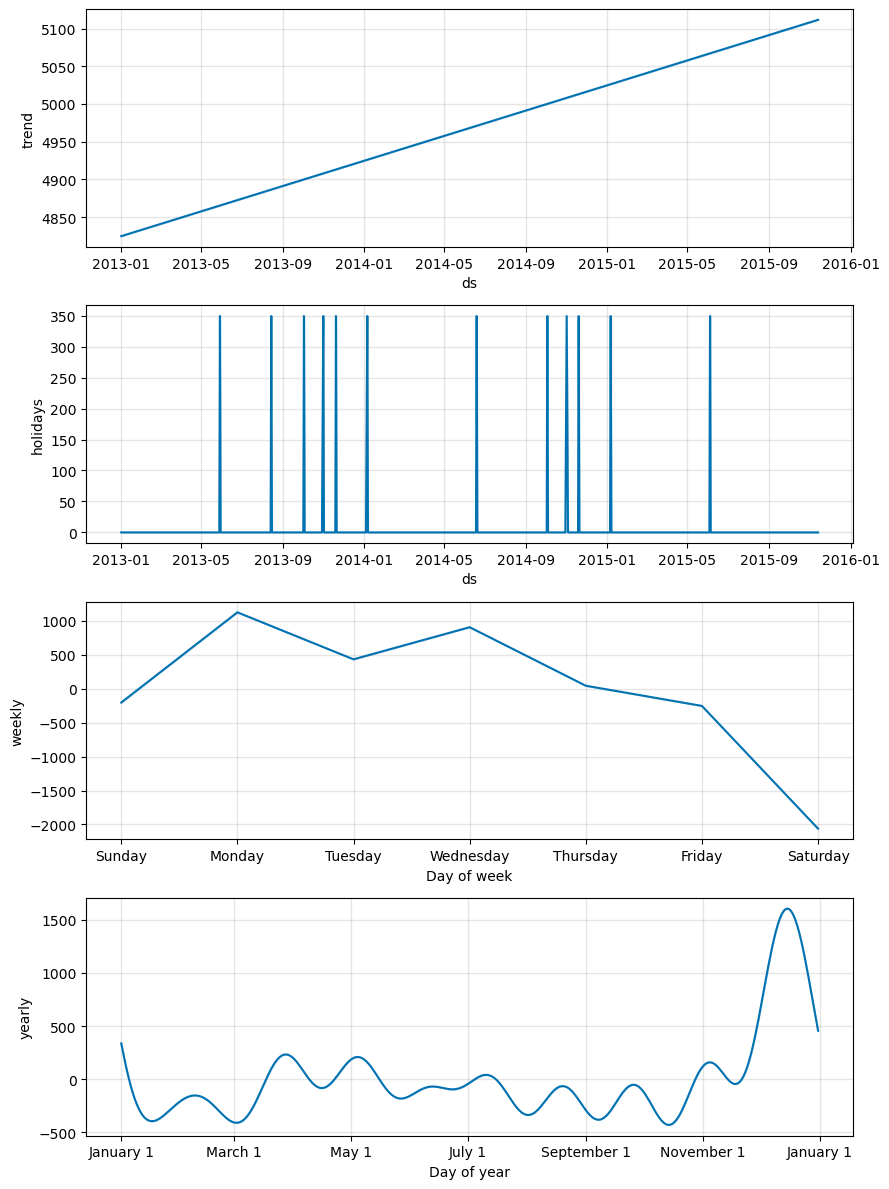

In [3]:
# import the required libraries
import pandas as pd
import matplotlib.pyplot as plt

# import the required libraries for time series analysis
from statsmodels.tsa.seasonal import seasonal_decompose

# import the forecasting library which in this case, we are using Meta's Prophet because it is a powerful library for time series forecasting
# and is particularly well-suited for handling seasonal data with holidays and other events.
from prophet import Prophet


# load the sales dataset for later use
data = pd.read_csv("DATASETS/train.csv", low_memory=False)

# convert the 'Date' column to datetime type
data['Date'] = pd.to_datetime(data['Date'])

# filter out rows where the store is closed or sales are zero. These rows are not useful for time series modeling and can introduce noise into the analysis.
# we also filter out rows where sales are zero, as they do not contribute to the analysis.
filtered_data = data[(data['Open'] != 0) & (data['Sales'] > 0)]

# ensure 'Sales' is in float format for numerical processing and analysis
# convert 'Sales' to float type to ensure proper numerical operations
filtered_data['Sales'] = filtered_data['Sales'].astype(float)


# select one store from each store type to represent its trend. 
stores = {
    "A": 2,
    "B": 85,
    "C": 1,
    "D": 13
}

# plot weekly aggregated sales for each selected store type
# create a figure with subplots for each store type
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(14, 14), sharex=True)

# iterate through the selected stores and plot their weekly sales trends
for idx, (store_type, store_id) in enumerate(stores.items()):
    # filter for specific store and set 'Date' as index. 
    store_data = filtered_data[filtered_data['Store'] == store_id].set_index('Date')

    # resample daily data into weekly totals using 'W' frequency
    # this aggregates the sales data into weekly totals, which helps in understanding the overall trend over time.
    weekly_sales = store_data['Sales'].resample('W').sum()

    # plot the weekly sales trend for the store type
    # the plot shows the total sales for each week, which helps in visualizing the sales trend over time.
    weekly_sales.plot(ax=axes[idx], title=f"Weekly Sales - StoreType {store_type}", legend=False)
    axes[idx].set_ylabel("Sales")

plt.xlabel("Date")
plt.tight_layout()
plt.show()


# decompose seasonal trends for each store's daily sales data
# create a figure with subplots for each store type
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(14, 14), sharex=True)

# iterate through the selected stores and decompose their daily sales data
for idx, (store_type, store_id) in enumerate(stores.items()):
    # get daily sales data for decomposition 
    daily_sales = filtered_data[filtered_data['Store'] == store_id].set_index('Date')['Sales']

    # apply seasonal decomposition with a period of 7 days (weekly trend). We are using an additive model to decompose the time series into trend, seasonal, and residual components.
    # the period of 7 is chosen because we expect weekly seasonality in the sales data.
    result = seasonal_decompose(daily_sales, model='additive', period=7)

    # plot only the trend component for each store type
    result.trend.plot(ax=axes[idx], title=f"Trend Component - StoreType {store_type}")
    axes[idx].set_ylabel("Trend")

plt.xlabel("Date")
plt.tight_layout()
plt.show()


# select data for a single store (Store #1 - StoreType C)
store_df = filtered_data[filtered_data['Store'] == 2][['Date', 'Sales']].copy()

# prophet requires 'ds' for dates and 'y' for values
store_df.rename(columns={'Date': 'ds', 'Sales': 'y'}, inplace=True)
store_df = store_df.sort_values(by='ds')  # Ensure chronological order

# create holiday features from dataset
state_holidays = data[data['StateHoliday'].isin(['a', 'b', 'c'])]['Date']
school_holidays = data[data['SchoolHoliday'] == 2]['Date']

# build holidays DataFrame in Prophet's format
holiday_df = pd.concat([
    pd.DataFrame({'holiday': 'state_holiday', 'ds': pd.to_datetime(state_holidays)}),
    pd.DataFrame({'holiday': 'school_holiday', 'ds': pd.to_datetime(school_holidays)})
]).drop_duplicates()

# initialize Prophet model with holidays and wider uncertainty interval
model = Prophet(interval_width=0.95, holidays=holiday_df)

# fit the model to the store's data
model.fit(store_df)

# create a future DataFrame extending 6 weeks (15*7 = 105 days)
future_dates = model.make_future_dataframe(periods=105)

# predict future sales
forecast = model.predict(future_dates)

# plot the forecast along with actual data
model.plot(forecast)
plt.title("Forecasted Sales - Store 2 (Prophet)")
plt.show()

# plot forecast components: trend, seasonality, holidays
model.plot_components(forecast)
plt.show()


